<a href="https://colab.research.google.com/github/saichandra42/DeepQLearningForChess/blob/main/Assignment1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"I (Sai Chandra Rachiraju) certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."

In [ ]:
%pip install gym

In [ ]:
%pip install tabulate

In [ ]:
% pip install tqdm

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
from gym import spaces
from tabulate import tabulate

In [ ]:
class Chess(gym.Env):
  def __init__(self,size,hyper_params = {}):
    self.size = size
    self.possible_actions = 8
    self.observation_space = spaces.MultiDiscrete([ size, size ])
    self.q_table = np.zeros((size*size,self.possible_actions))
    self.action_space = spaces.MultiDiscrete(self.possible_actions)
    self.rewards = []
    self.decay = []

    # State map
    self.stateMap = {}
    for i in range(0,self.size):
        for j in range(0,self.size):
            key=str(i)+str(j)
            self.stateMap[key] = None
            
    for index,element in enumerate(self.stateMap.keys()):
        self.stateMap[element] = index

    # Parameters of the model
    self.agent_current_pos = self.observation_space.sample()
    #self.target_pos = self.observation_space.sample()
    self.target_pos = [0,0]

    # Hyperparameters of this model
    self.total_episodes = hyper_params.get('total_episodes',100)
    self.learning_rate = hyper_params.get('learning_rate',0.01)
    self.max_steps = hyper_params.get('max_steps',100)
    self.gamma = hyper_params.get('gamma',0.95)
    self.epsilon = hyper_params.get('epsilon',0.7)
    self.bypass = hyper_params.get('bypass',False)

  def manhattanDistance(self,currentPosition,targetPosition):
    [x,y] = currentPosition
    [target_x,target_y] = targetPosition
    distance = np.sum(np.abs(np.array([target_x - x,target_y-y])))
    return distance

  def step(self,action = 0):
    before_action = self.agent_current_pos
    [x,y] = self.agent_current_pos
    [target_x,target_y] = self.target_pos
        
    if action == 0 and x <=6 and y<=5:
      # Go one step right and two steps up
      self.agent_current_pos[0] += 1
      self.agent_current_pos[1] += 2
      
    elif action == 1 and x<=6 and y>= 2:
      # Go one step right and two steps down
      self.agent_current_pos[0] += 1
      self.agent_current_pos[1] -= 2

    elif action == 2 and x<=6 and y<=5:
      # Go two steps right and one step up
      self.agent_current_pos[0] += 2
      self.agent_current_pos[1] += 1

    elif action == 3 and x<=6 and y>=1:
      # Go two steps right and one step down
      self.agent_current_pos[0] += 2
      self.agent_current_pos[1] -= 1
    
    elif action == 4 and x>=1 and y<=5:
      # Go one step left and two steps up
      self.agent_current_pos[0] -= 1
      self.agent_current_pos[1] += 2

    elif action == 5 and x>=1 and y>=2:
      # Go one step left and two steps down
      self.agent_current_pos[0] -= 1
      self.agent_current_pos[1] -= 2

    elif action == 6 and x>=2 and y<=6:
      # Go two steps left and one step up
      self.agent_current_pos[0] -= 2
      self.agent_current_pos[1] += 1

    elif action == 7 and x>=2 and y>=1:
      # Go two steps left and one step bottom
      self.agent_current_pos[0] -= 2
      self.agent_current_pos[1] -= 1

    self.agent_current_pos = np.clip(self.agent_current_pos,a_min = 0,a_max = self.size-1)

    # Defining 4 possible rewards
    reward = 0
    distance = self.manhattanDistance(self.agent_current_pos,self.target_pos)

    # 8 possible actions (Knight in chess)
    [x,y] = self.agent_current_pos
    are_on_same_level = ((target_x == x) and (target_y !=  y)) or ((target_x != x) and (target_y == y))
    [target_x,target_y] = self.target_pos
    target_reached = np.all(self.agent_current_pos == self.target_pos)
    no_action = np.all(before_action == self.agent_current_pos)

    if distance == 0:
      # On target
      reward = 1
    elif (not are_on_same_level & distance == 3):
      # Nearing the target by 1 more move
      reward = 0.5
    elif (not are_on_same_level & distance == 2):
      # Nearing the target by 2 more moves (on the same level)
      reward = 0.2
    elif distance == 1:
      # Just beside the target, nearing in 3 moves
      reward = 0.1
    elif no_action:
      # Is still away from target
      reward = -1
    else:
      reward = 0
    
    
    # Safety of the environment check
    self.agent_current_pos = np.clip(self.agent_current_pos,a_min = 0,a_max = self.size-1)
    new_state = self.positionToState(self.agent_current_pos)
    target_state = self.positionToState(self.target_pos)
      
    action_dict = {
        'new_state': new_state,
        'reward': reward,
        'done': (np.all(new_state == target_state)),
        'distance': distance,
        'info': {
            'current_position': self.agent_current_pos,
            'target_position': self.target_pos,
            'action_index': action
        }
    }
    return action_dict
  
  def positionToState(self,currentPosition):
      [x,y] = currentPosition
      return self.stateMap[str(x)+str(y)]

  def reset(self):
    self.agent_current_pos = self.observation_space.sample()
    return self.positionToState(self.agent_current_pos)
    #self.observation_space = spaces.MultiDiscrete([ self.size, self.size ])
    #self.q_table = np.zeros((self.size*self.size,self.possible_actions))
    #self.action_space = spaces.MultiDiscrete(self.possible_actions)
  
  def render(self):
    [x_pos, y_pos] = self.agent_current_pos
    # To distinguish from white and black spaces
    rendering_env = np.zeros((self.size,self.size))
    for row_index,row in enumerate(rendering_env):
      for column_index,element in enumerate(row):
        if (row_index+column_index)%2 == 0:
          rendering_env[row_index][column_index] = 1

    [x_target_pos, y_target_pos] = self.target_pos
    plt.imshow(rendering_env,cmap = 'gray',interpolation='nearest')
    plt.text(x_pos, y_pos, s = 'K', bbox=dict(fill=True, boxstyle='square',color='yellow'))
    plt.text(x_target_pos, y_target_pos, s='T',bbox=dict(fill=True, boxstyle='square',color='green'))
    plt.xticks(range(self.size))
    plt.title("K=Knight and T=Target")
    plt.show()

  def train(self):
    loop = tqdm(enumerate(range(self.total_episodes)),total=self.total_episodes)
    for _,episode in loop:
        self.reset()
        reward_per_episode = 0
        counter = 1
        state = self.positionToState(self.agent_current_pos)
        done = False
        while (not done) and (counter <= self.max_steps):
          # Creating an explore/exploit scenario
          cutoff = np.random.uniform(0,1)
          action_to_be_taken = None

          if cutoff > self.epsilon:
              # Exploit by taking the best action in the table
              # Once the values are done,then exploit
              action_to_be_taken = np.argmax(self.q_table[state,:])
          else:
              # Explore the scenario
              # Initially should explore
              action_to_be_taken = np.random.randint(low=0,high=self.possible_actions)
          
          action_info = self.step(action_to_be_taken)
          reward_received = action_info['reward']
          reward_per_episode += reward_received
          counter += 1
          new_state = action_info.get('new_state',0)

          #Updating the Q Table
          current_q_value = self.q_table[state,action_to_be_taken]
          max_q_value = np.max(self.q_table[new_state, :])
          self.q_table[state, action_to_be_taken] = ((1-self.learning_rate) * current_q_value) + (self.learning_rate * (reward_received + self.gamma * max_q_value))
        
        self.epsilon = 0.01 + (1-0.01)* np.exp(-0.005 * episode)
        self.decay.append(self.epsilon)
        self.rewards.append(reward_per_episode)

  def plot_reward(self):
    plt.figure(figsize=(20,12))
    plt.plot(self.rewards)  
    plt.show()

  def plot_decay(self):
    plt.figure(figsize=(20,12))
    plt.plot(self.decay)  
    plt.show()

  def show_table(self):
    print(tabulate(self.q_table,headers=list(range(0,8)),tablefmt="pretty",showindex="always"))

In [ ]:
params = {
    "total_episodes": 10000,
    "learning_rate": 0.05,
    "max_steps": 200,
    "gamma":0.95,
    "epsilon": 1
}
chess = Chess(8,params)

In [ ]:
sample_action = chess.action_space.sample()
chess.step(sample_action)

{'distance': 6,
 'done': False,
 'info': {'action_index': 4,
  'current_position': array([0, 6]),
  'target_position': [0, 0]},
 'new_state': 6,
 'reward': 0.5}

In [ ]:
chess.train()

100%|██████████| 10000/10000 [04:57<00:00, 33.64it/s]


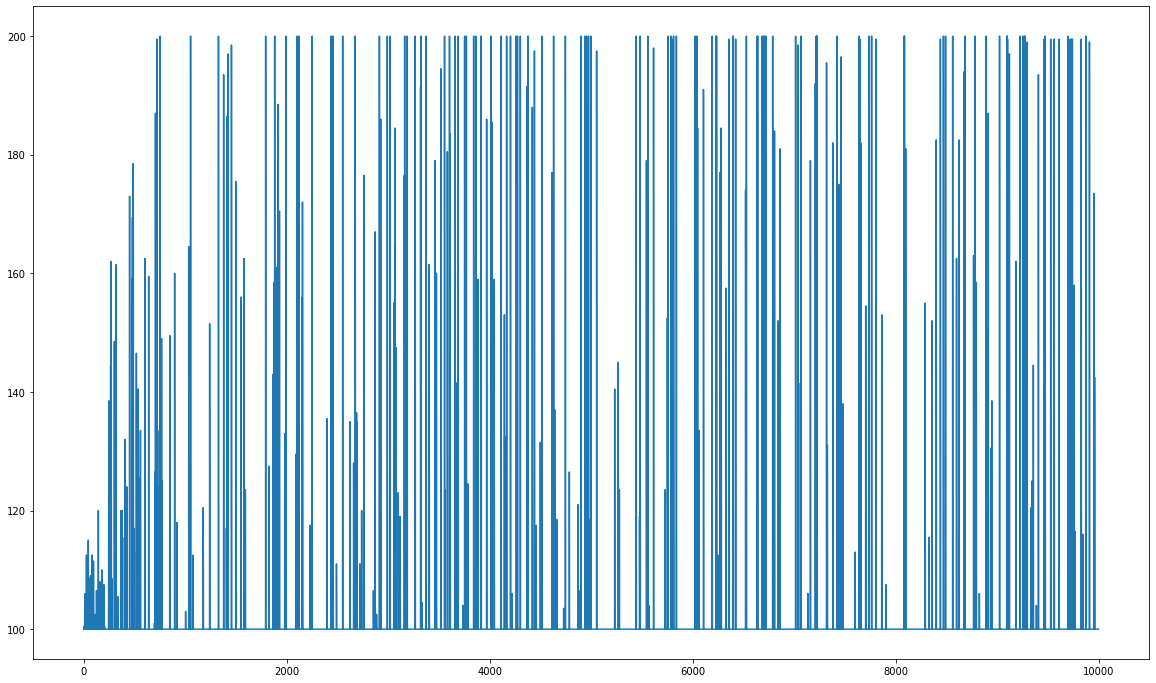

In [ ]:
chess.plot_reward()

In [ ]:
#chess.plot_decay()

In [ ]:
#chess.show_table()

# Deep Q Learning

In [ ]:
import torch as torch
from torch.autograd import Variable

In [ ]:
params = {
    "total_episodes": 2,
    "learning_rate": 0.05,
    "max_steps": 200,
    "gamma":0.95,
    "epsilon": 1
}

In [ ]:
class DeepQNetwork(torch.nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim = 16, lr=0.05):
      super(DeepQNetwork,self).__init__()
      self.state_dim = state_dim
      self.action_dim = action_dim
      self.criterion = torch.nn.MSELoss()
      self.model = torch.nn.Sequential(
                      torch.nn.Linear(state_dim, hidden_dim),
                      torch.nn.LeakyReLU(),
                      torch.nn.Linear(hidden_dim, hidden_dim*2),
                      torch.nn.LeakyReLU(),
                      torch.nn.Linear(hidden_dim*2, action_dim)
              )
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, state, y):
      y_pred = self.model(torch.Tensor(state))
      loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


    def predict(self, state):
      state_vector = np.zeros(self.state_dim)
      with torch.no_grad():
        return self.model(torch.Tensor(state_vector))

In [ ]:
network = DeepQNetwork(64,8)

In [ ]:
def deep_q_learning(env,model,learning_params={}):
  n_episodes = learning_params.get('episodes',10)
  epsilon = learning_params.get('epsilon',10)
  replay = learning_params.get('replay',False)
  gamma = learning_params.get('gamma',0.9)
  replay_size = learning_params.get('replay_size',10)

  loop = tqdm(enumerate(range(n_episodes)),total=n_episodes)
  rewards = []
  memory = []

  for _,episode in loop:
    done = False
    state = env.reset()
    episode_reward = 0
    # State is a number from 0 to 63 to indicate 64 states of the board if size is 8
    while not done:
      cutoff = np.random.uniform(0,1)
      if cutoff < epsilon:
        # Taking a random action
        action = chess.action_space.sample()
      else:
        # Exploit the environment 
        q_values = model.predict(state)
        action = torch.argmax(q_values).item()
      
      action_dict = env.step(action)
      next_state = action_dict.get("next_state")
      reward_received = action_dict.get("reward")
      done = action_dict.get("done")
      
      episode_reward += reward_received
      memory.append(action_dict)
      q_values = model.predict(state).tolist()

      # # If the knight reached the target
      # if done:
      #   pass
      # else:
      #   next_q_values = model.predict(next_state)
      #   max_q_value = torch.max(next_q_values).item()
      #   q_values[action] = reward_received + (gamma * max_q_value)

    rewards.append(episode_reward)

In [ ]:
learning_params = {
    'episodes': 2,
    'gamma': 0.9,
    'epsilon': 0.5
}

In [ ]:
deep_q_learning(chess,network,learning_params)

100%|██████████| 2/2 [00:00<00:00, 16.15it/s]
